In [113]:
import pandas as pd
import numpy as np

from datetime import datetime

from sklearn import decomposition
from sklearn.ensemble import *
from sklearn.feature_selection import *
from sklearn.model_selection import *
from sklearn.preprocessing import *

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

import csv
import time
import copy
import os
import tempfile

In [249]:
data = pd.read_csv('train_final.csv')
data.head()

,avg_travel_time,last_att,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation,ls_0_in_out_diff,...,ls_5_117,ls_6_103,ls_6_118,ls_6_121,ls_8_101,ls_8_113,ls_7_106,ls_7_116,ls_7_122,ls_9_121
0,85.405,85.405,0.248927,0.25,0.608333,0.44,0.529644,0.767123,0.0,-1,...,1,0,0,0,0,0,0,0,0,0
1,58.050,85.405,0.248927,0.25,0.608333,0.44,0.529644,0.767123,0.0,-1,...,1,0,0,0,0,0,0,0,0,0
2,67.895,58.050,0.248927,0.25,0.608333,0.44,0.529644,0.767123,0.0,-1,...,1,0,0,0,0,0,0,0,0,0
3,67.895,67.895,0.248927,0.25,0.608333,0.44,0.529644,0.767123,0.0,-1,...,1,0,0,0,0,0,0,0,0,0
4,56.870,67.895,0.248927,0.25,0.608333,0.44,0.529644,0.767123,0.0,-1,...,1,0,0,0,0,0,0,0,0,0


In [281]:
def reshape_data(x, y, time_steps):
    x_new, y_new = [], []
    for i in range(time_steps - 1):
        x_new.append(np.concatenate((x[0:i+1, :], np.array([x[i] for j in range(i+1, time_steps)]))))
        y_new.append(y[i])
    for i in range(len(x) - time_steps + 1):
        x_new.append(x[i:(i + time_steps), :])
        y_new.append(y[i])
    return x_new, y_new
        
def split_data(data, time_steps):
    train_data, val_data = train_test_split(data, test_size=0.20, shuffle=False)

    train_target = np.array(train_data.pop('avg_travel_time'))
    val_target = np.array(val_data.pop('avg_travel_time'))
    
    train_data, train_target = reshape_data(np.array(train_data), train_target, time_steps)
    val_data, val_target = reshape_data(np.array(val_data), val_target, time_steps)

    return train_data, train_target, val_data, val_target

In [282]:
# train_data, val_data = train_test_split(data, test_size=0.20, shuffle=False)

# train_target = np.array(train_data.pop('avg_travel_time'))
# val_target = np.array(val_data.pop('avg_travel_time'))
# (31444, 141)

train_data, train_target, val_data, val_target = split_data(data, 6)
# val_data, val_target = univariate_data(data, TRAIN_SPLIT, None,
#                                        univariate_past_history,
#                                        univariate_future_target)

In [283]:
BATCH_SIZE = 72
BUFFER_SIZE = 72

train_rnn = tf.data.Dataset.from_tensor_slices((train_data, train_target))
# train_rnn = train_rnn.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_rnn = train_rnn.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_rnn = tf.data.Dataset.from_tensor_slices((np.array(val_data), np.array(val_target)))
val_rnn = val_rnn.batch(BATCH_SIZE)

In [284]:
def mape(y_true, y_pred):
    return K.mean(K.abs((y_true - y_pred) / y_true), axis=-1)

def build_model(dim):
    
    lstm_model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(32, input_shape=dim, 
                             return_sequences=True,
                             kernel_regularizer=L1L2(l1=0.0,l2=0.001)),
        tf.keras.layers.LSTM(16, kernel_regularizer=L1L2(l1=0.0,l2=0.001)),
        tf.keras.layers.Dense(1, activation='linear')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

    lstm_model.compile(loss='mae',
                  optimizer=optimizer,
                  metrics=[mape])
    
    return lstm_model

class PrintProgress(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print('.', end='')
        if (epoch+1) % 10 == 0: 
            print(' ')
            logs_new = copy.deepcopy(logs)
            print(logs_new)


In [285]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)            
            
EPOCHS = 25
EVALUATION_INTERVAL = 200

lstm_model = build_model(np.array(train_data).shape[-2:])

history = lstm_model.fit(train_rnn, epochs=EPOCHS,
                      validation_data=val_rnn, 
                        verbose=1)


Epoch 1/25
437/437 [==============================] - 13s 30ms/step - loss: 107.3320 - mape: 0.9210 - val_loss: 171.0423 - val_mape: 0.9240
Epoch 2/25
437/437 [==============================] - 7s 15ms/step - loss: 98.8026 - mape: 0.8270 - val_loss: 163.3435 - val_mape: 0.8790
Epoch 3/25
437/437 [==============================] - 7s 17ms/step - loss: 91.2228 - mape: 0.7469 - val_loss: 155.8088 - val_mape: 0.8350
Epoch 4/25
437/437 [==============================] - 7s 17ms/step - loss: 83.7919 - mape: 0.6698 - val_loss: 148.3502 - val_mape: 0.7914
Epoch 5/25
437/437 [==============================] - 8s 17ms/step - loss: 76.5144 - mape: 0.5956 - val_loss: 140.9731 - val_mape: 0.7483
Epoch 6/25
437/437 [==============================] - 8s 18ms/step - loss: 69.6016 - mape: 0.5278 - val_loss: 133.7897 - val_mape: 0.7065
Epoch 7/25
437/437 [==============================] - 9s 20ms/step - loss: 63.4176 - mape: 0.4719 - val_loss: 126.9795 - val_mape: 0.6668
Epoch 8/25
437/437 [============

In [206]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
    plt.legend()
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['mape'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mape'],
           label = 'Val Error')
    plt.legend()
    
    plt.show()

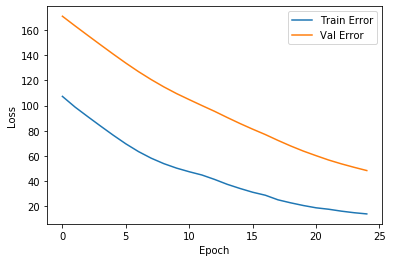

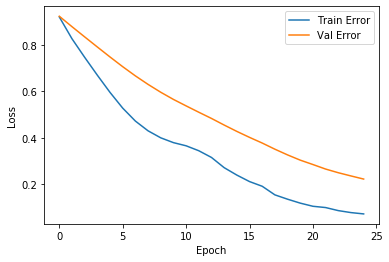

In [288]:
plot_history(history)

In [126]:
test_data = pd.read_csv('test_final.csv')
test_data.head()

,avg_travel_time,last_att,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation,ls_0_in_out_diff,...,ls_5_117,ls_6_103,ls_6_118,ls_6_121,ls_8_101,ls_8_113,ls_7_106,ls_7_116,ls_7_122,ls_9_121
0,41.097143,41.097143,0.746781,0.745763,0.355556,0.213333,0.367589,0.657534,0.0,-1,...,1,0,0,0,0,0,0,0,0,0
1,43.681667,41.097143,0.746781,0.745763,0.355556,0.213333,0.367589,0.657534,0.0,-1,...,1,0,0,0,0,0,0,0,0,0
2,68.024286,43.681667,0.746781,0.745763,0.355556,0.213333,0.367589,0.657534,0.0,-1,...,1,0,0,0,0,0,0,0,0,0
3,52.608333,68.024286,0.746781,0.745763,0.355556,0.213333,0.367589,0.657534,0.0,-1,...,1,0,0,0,0,0,0,0,0,0
4,56.165556,52.608333,0.746781,0.745763,0.355556,0.213333,0.367589,0.657534,0.0,-1,...,1,0,0,0,0,0,0,0,0,0


In [127]:
test_label = test_data.pop('avg_travel_time')

In [287]:
tx, ty = reshape_data(np.array(test_data), test_label, 6)
result = lstm_model.predict(np.array(tx))
mape_score = np.mean(np.abs((test_label - [r[0] for r in result]) / test_label))
mape_score

0.26701369991334234